# Throughput - Multiple Teams - Multi-plot

Fitting data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

This note contains an example analysis for 6 teams. 

This note demonstrates how to use the multi-plot feature of GNUplot.

## Table of contents

* [Set-up](#Set-up)
* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Analyze the data](#Analyze-the-data)
* [Fitting the data to a Poisson distribution](#Fitting-the-data-to-a-Poisson-distribution)
* [Forecasting using a Poisson distribution](#Monte-Carlo)
* [References](#Forecasting-using-a-Poisson-distribution)
* [Tear-down](#Tear-down)

## Set-up

In [1]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math

Exboost.Math

## Data and simulation set-up

As an example consider the throughput of completed backlog items. At the end of a fixed time period we count the number of backlog items that a team completes. Partially completed items are excluded from the count.

The periods for (almost) all teams in this note is 15 days (half a month). Two periods equals 1 month. For most of the data a bin size of 5 is appropriate. This is made specific in the structure describing the team data below.

In [2]:
# The size of the bins
binsize = 5
:"do not show this result in output"

The following shows the sequences for the throughput (number of work items completed per period) for six teams. The most recent period is the first item in the list. Note that fort all teams the global bin size (see above) applies except for teams 5 for which we will use a bin size of 5.

In [3]:
all_data = %{
    "Team 1" => [69,41,53,41,41,48,69,15,15,12,12,15,31,78,62,16,25,28,25,38,16],
    "Team 2" => [50,68,36,50,50,68,36,19,15,23,9,15,3,23,23,9,14,2,9,9,14,19,11,0,1,1,1],
    "Team 3" => [55,46,46,70,55,70,91,67,49,7,20,34,68,68,20,31,0,0,0,0,0,4,0,0,0,3],
    "Team 4" => [55,47,65,50,50,50,57,44,27,25,14,23,30],
    "Team 5" => [
        throughput: [11,4,11,3,6,0],
        bin: 1
    ],
    "Team 6" => [70,70,86,116,70,103,103,116,73,28,28,35,26,35,70,32,32,26,60,37,19,37,19,16,10,13,31,37,31,24,16,37,3,2,2,4,2,2],
}
:"do not show this result in output"

Parameters that affect the Monte Carlo simulations are listed below. Please adjust to your needs.

In [4]:
# Number of iterations to use in the Monte Carlo
iterations = 1000

# Number of probes to use in the chi2 fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
initial = [{1,100}]
:"do not show this result in output"

Later on in this note we will forecast to provide a statistical answer to the questions:
1. How many periods do we need to complete a certain amount of work items?
1. How many work items can the team complete in a certain amount of periods?

In [5]:
# The size of the backlog, e.g. 100 backlog items
size = 1000

# The number of periods to forecast the number of completed work items
periods = 6
:"do not show this result in output"

We will start by showing a histogram of the raw throughput data:

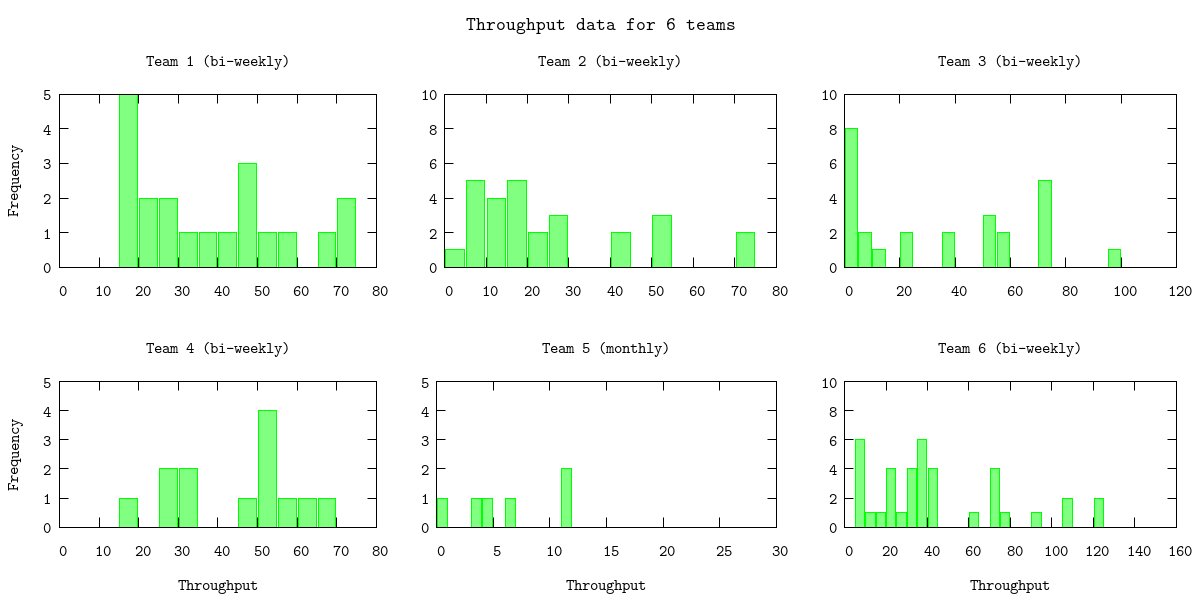

In [6]:
P.multi([
    P.histogram(all_data["Team 1"], bin: 5, plottitle: "Team 1 (bi-weekly)", ylabel: "Frequency", xrange: '[0:80]', yrange: '[:5]', mode: :as_commands),
    P.histogram(all_data["Team 2"], bin: 5, plottitle: "Team 2 (bi-weekly)", xrange: '[0:80]', yrange: '[:10]', mode: :as_commands),
    P.histogram(all_data["Team 3"], bin: 5, plottitle: "Team 3 (bi-weekly)", xrange: '[0:120]', yrange: '[:10]', mode: :as_commands),
    P.histogram(all_data["Team 4"], bin: 5, plottitle: "Team 4 (bi-weekly)", xlabel: "Throughput", ylabel: "Frequency", xrange: '[0:80]', yrange: '[:5]', mode: :as_commands),
    P.histogram(all_data["Team 5"][:throughput], bin: 1, xlabel: "Throughput", plottitle: "Team 5 (monthly)", xrange: '[0:30]', yrange: '[:5]', mode: :as_commands),
    P.histogram(all_data["Team 6"], bin: 5, xlabel: "Throughput", plottitle: "Team 6 (bi-weekly)", xrange: '[0:160]', yrange: '[:10]', mode: :as_commands),
], columns: 3, title: "Throughput data for 6 teams", size: "1200,600")
:"this is an inline image"

## Analyze the data

We will use the Poisson distribution to model the squad data.

In [7]:
model = D.model "poisson"
options = [probes: probes, model: :linear, fitmodel: model, init: initial, bin: binsize]
:"do not show this result in output"

Next, we analyze the team data to find any (sudden) changes in the delivery rate, or throughput. We are interested in the most recent largest sequence of data that corresponds to the same delivery rate.

In [8]:
recent = U.analyze(
    all_data,
    fn data,opt ->
        [{chi,params,subdata}|_] = F.find_all(data[:throughput],opt)
        [
            throughput: subdata,
            parameters: params,
            minchi2: chi
        ]
    end,
    options)
|> IO.inspect(charlists: :as_lists)
:"do not show this result in output"

%{
  "Team 1" => [
    bin: 5,
    throughput: [69, 41, 53, 41, 41, 48, 69],
    parameters: [49.04610809065387],
    minchi2: 0.2273646678836093
  ],
  "Team 2" => [
    bin: 5,
    throughput: [50, 68, 36, 50, 50, 68, 36],
    parameters: [45.59124553167136],
    minchi2: 0.03576613716878602
  ],
  "Team 3" => [
    bin: 5,
    throughput: [55, 46, 46, 70, 55, 70, 91, 67, 49],
    parameters: [55.7080939226301],
    minchi2: 0.3657526673879149
  ],
  "Team 4" => [
    bin: 5,
    throughput: [55, 47, 65, 50, 50, 50, 57, 44, 27],
    parameters: [45.787879253496556],
    minchi2: 6.944341156717606
  ],
  "Team 5" => [
    bin: 1,
    throughput: [11, 4, 11, 3, 6, 0],
    parameters: [4.020222158199639],
    minchi2: 2.9980546408784488
  ],
  "Team 6" => [
    bin: 5,
    throughput: [70, 70, 86, 116, 70],
    parameters: [74.4656283764881],
    minchi2: 1.2094138493022724
  ]
}


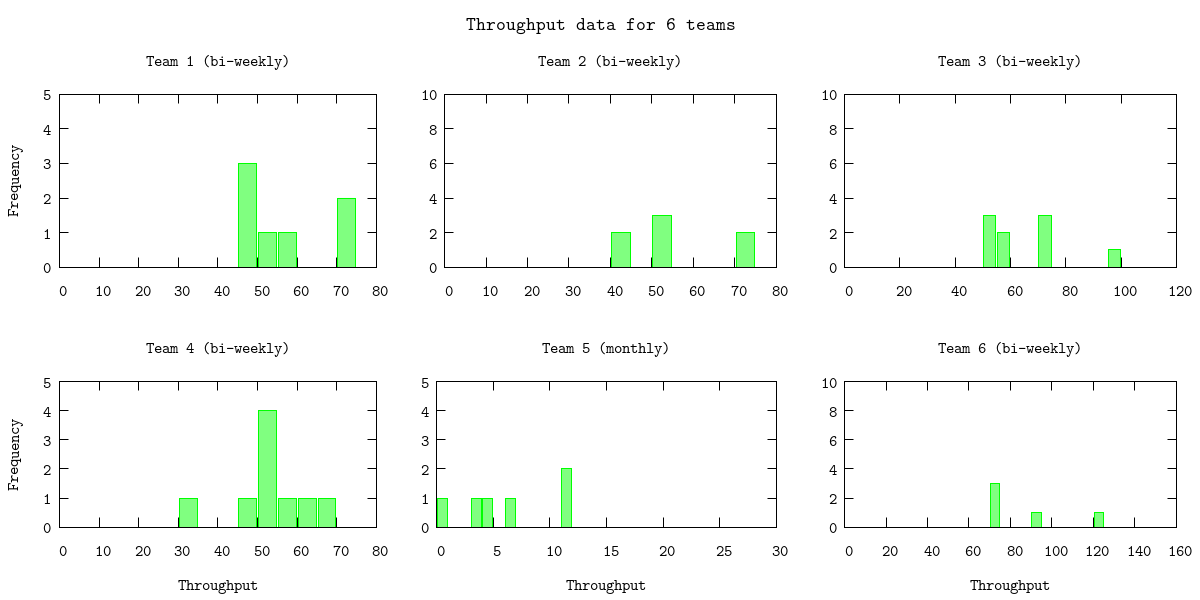

In [9]:
P.multi([
    P.histogram(recent["Team 1"][:throughput], bin: 5, plottitle: "Team 1 (bi-weekly)", ylabel: "Frequency", xrange: '[0:80]', yrange: '[:5]', mode: :as_commands),
    P.histogram(recent["Team 2"][:throughput], bin: 5, plottitle: "Team 2 (bi-weekly)", xrange: '[0:80]', yrange: '[:10]', mode: :as_commands),
    P.histogram(recent["Team 3"][:throughput], bin: 5, plottitle: "Team 3 (bi-weekly)", xrange: '[0:120]', yrange: '[:10]', mode: :as_commands),
    P.histogram(recent["Team 4"][:throughput], bin: 5, plottitle: "Team 4 (bi-weekly)", ylabel: "Frequency", xlabel: "Throughput", xrange: '[0:80]', yrange: '[:5]', mode: :as_commands),
    P.histogram(recent["Team 5"][:throughput], bin: 1, plottitle: "Team 5 (monthly)", xlabel: "Throughput", xrange: '[0:30]', yrange: '[:5]', mode: :as_commands),
    P.histogram(recent["Team 6"][:throughput], bin: 5, plottitle: "Team 6 (bi-weekly)", xlabel: "Throughput", xrange: '[0:160]', yrange: '[:10]', mode: :as_commands),
], columns: 3, title: "Throughput data for 6 teams", size: "1200,600")
:"this is an inline image"

## Fitting the data to a Poisson distribution

Instead of directly using the raw data captured one can also use a known probability distribution. The parameter of the distribution is matched to the data. After matching the parameter value one uses the known distribution to forecast.

Here, we will use the __Poisson distribution__ [1]. This basically assumes that the data points are independent of each other. For most teams we expect this to be a more than reasonable choice.

In [10]:
fits = recent
|> U.analyze(
    fn dat,opt ->
        try do
            {chi2, cov, params, ranges} = dat[:throughput]
                |> U.to_bins({opt[:bin],0})
                |> F.chi2fit({dat[:parameters], Distribution.cdf(model), &F.nopenalties/2}, 10, opt)
            [
                minchi2: chi2,
                parameters: params,
                errors: Enum.zip(cov|>M.diagonal|>Enum.map(&:math.sqrt/1), tl(Tuple.to_list(ranges)))
            ]
        catch
            {:inverse_error, ArithmeticError, chi2, parameters} ->
            [
                minchi2: chi2,
                parameters: parameters
            ]
        end
    end,
    options |> Keyword.replace!(:probes,[]))
|> IO.inspect(charlists: :as_lists)
:"do not show this result in output"

%{
  "Team 1" => [
    bin: 5,
    throughput: [69, 41, 53, 41, 41, 48, 69],
    minchi2: 0.22736464561345177,
    parameters: [49.046523476293984],
    errors: [{2.783525072130074, [49.04569885379964, 49.046854230074146]}]
  ],
  "Team 2" => [
    bin: 5,
    throughput: [50, 68, 36, 50, 50, 68, 36],
    minchi2: 0.03576603513398336,
    parameters: [45.589742782177815],
    errors: [{4.70439870206486, [45.58874533134737, 45.591643243020464]}]
  ],
  "Team 3" => [
    bin: 5,
    throughput: [55, 46, 46, 70, 55, 70, 91, 67, 49],
    minchi2: 0.36575242307175115,
    parameters: [55.70925597635414],
    errors: [{2.3510098026343513, [55.7080939226301, 55.709979183064874]}]
  ],
  "Team 4" => [
    bin: 5,
    throughput: [55, 47, 65, 50, 50, 50, 57, 44, 27],
    minchi2: 6.94433993011686,
    parameters: [45.78713057129652],
    errors: [{0.6760045977863786, [45.786928652756956, 45.787879253496556]}]
  ],
  "Team 5" => [
    bin: 1,
    throughput: [11, 4, 11, 3, 6, 0],
    minchi2: 2.

## Forecasting using a Poisson distribution

For a (local) minimum the value of the gradient should be very close to zero which is the case. The value of chi-squared at the minimum is much, much smaller than 1. Usually values below 1 indicate a very good fit. Large errors on the data make it easy to fit a curve resulting in low values for chi-squared. Here, it means that the errors in the data are large.

In [11]:
t1 = fits["Team 1"]
t2 = fits["Team 2"]
t3 = fits["Team 3"]
t4 = fits["Team 4"]
t5 = fits["Team 5"]
t6 = fits["Team 6"]
:"do not show this result in output"

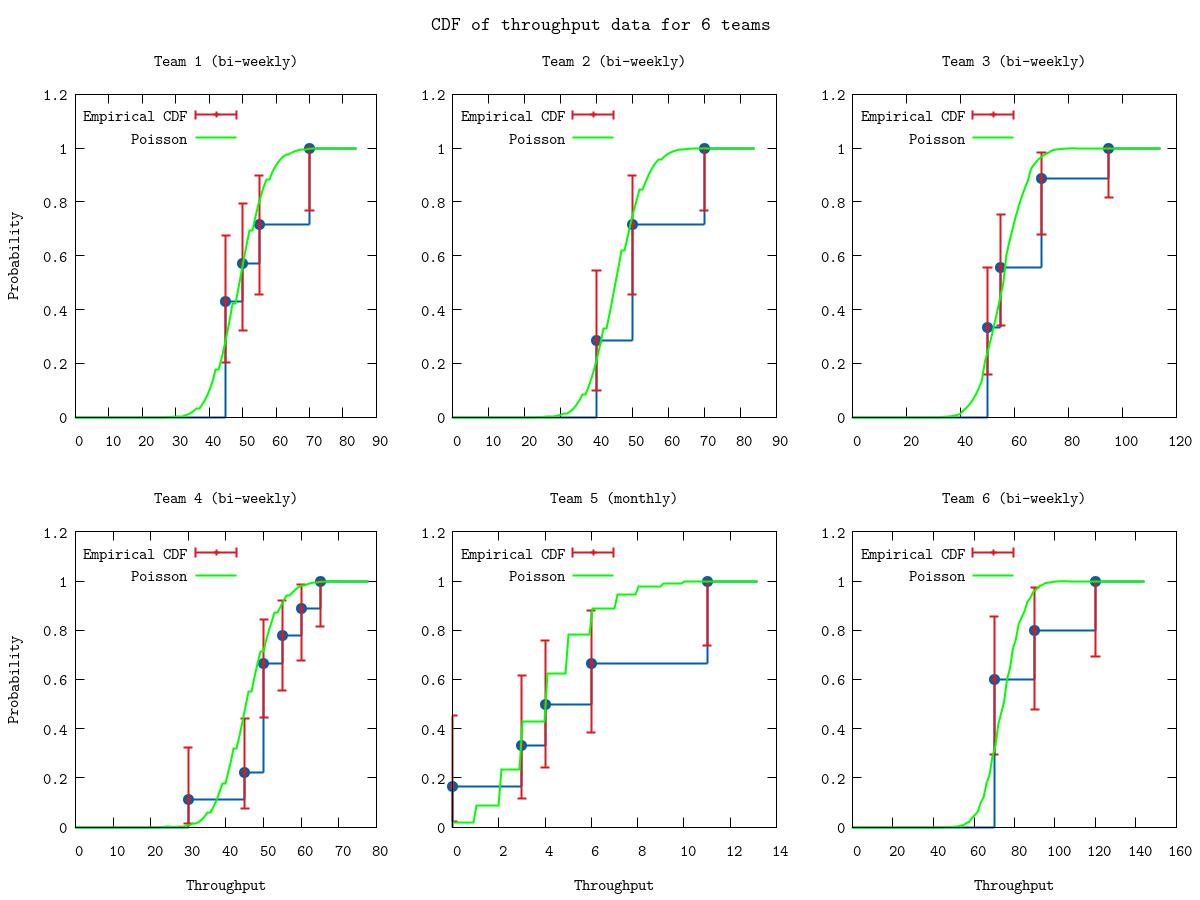

In [12]:
P.multi([
    P.ecdf(t1[:throughput] |> U.to_bins({5,0}),plottitle: "Team 1 (bi-weekly)",ylabel: "Probability",title: "Poisson",func: & Distribution.cdf(model).(&1,t1[:parameters]), mode: :as_commands),
    P.ecdf(t2[:throughput] |> U.to_bins({5,0}),plottitle: "Team 2 (bi-weekly)",title: "Poisson",func: & Distribution.cdf(model).(&1,t2[:parameters]), mode: :as_commands),
    P.ecdf(t3[:throughput] |> U.to_bins({5,0}),plottitle: "Team 3 (bi-weekly)",title: "Poisson",func: & Distribution.cdf(model).(&1,t3[:parameters]), mode: :as_commands),
    P.ecdf(t4[:throughput] |> U.to_bins({5,0}),plottitle: "Team 4 (bi-weekly)",xlabel: "Throughput",ylabel: "Probability",title: "Poisson",func: & Distribution.cdf(model).(&1,t4[:parameters]), mode: :as_commands),

    P.ecdf(t5[:throughput] |> U.to_bins({1,0}),plottitle: "Team 5 (monthly)",xlabel: "Throughput",title: "Poisson",func: & Distribution.cdf(model).(&1,t5[:parameters]), mode: :as_commands),
    P.ecdf(t6[:throughput] |> U.to_bins({5,0}),plottitle: "Team 6 (bi-weekly)",xlabel: "Throughput",title: "Poisson",func: & Distribution.cdf(model).(&1,t6[:parameters]), mode: :as_commands)
], columns: 3, title: "CDF of throughput data for 6 teams", size: "1200,900")
:"this is an inline image"

In [13]:
# Define the probability density for the Poisson distribution
poisson = fn x,[par] -> :math.exp(x*:math.log(par) - par - Math.lgamma(x+1.0)) end

#Function<12.127694169/2 in :erl_eval.expr/5>

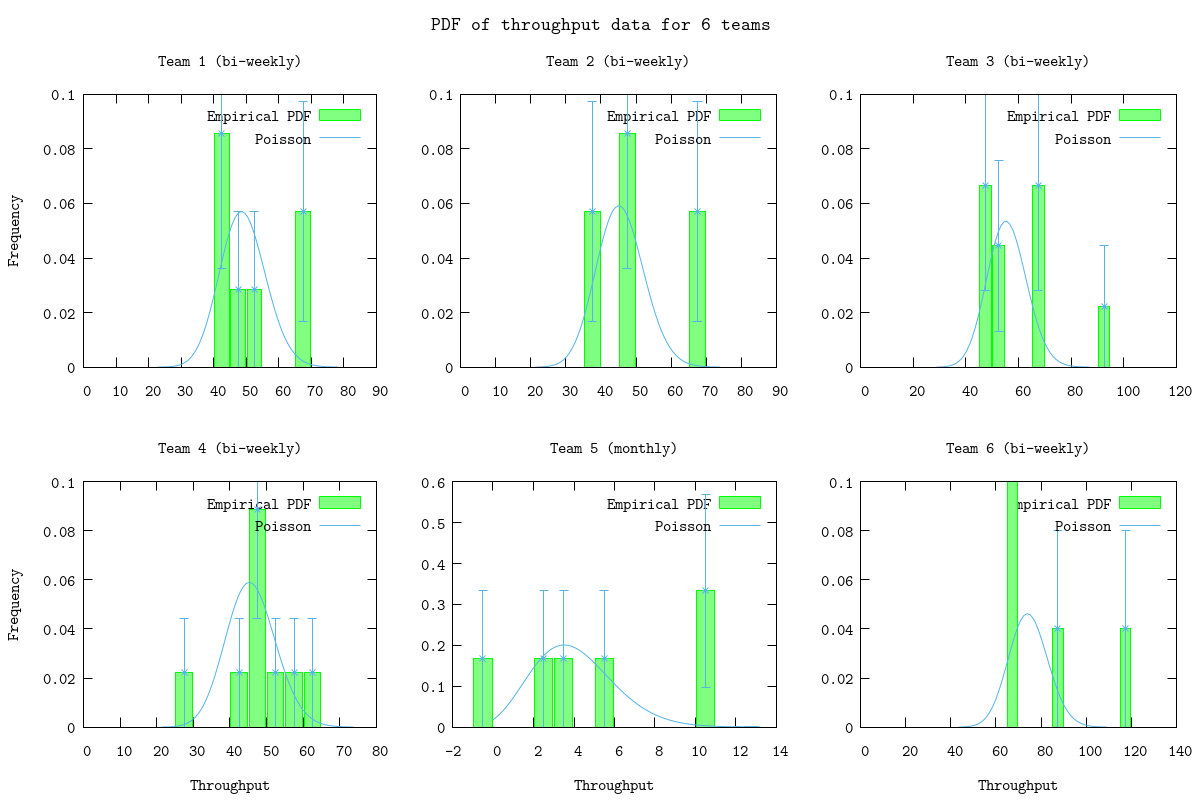

In [14]:
P.multi([
    P.pdf(t1[:throughput], plottitle: "Team 1 (bi-weekly)",ylabel: "Frequency",yrange: '[0:0.10]',pdf: &poisson.(&1,t1[:parameters]),title: "Poisson",bin: t1[:bin], mode: :as_commands),
    P.pdf(t2[:throughput], plottitle: "Team 2 (bi-weekly)",yrange: '[0:0.10]',pdf: &poisson.(&1,t2[:parameters]),title: "Poisson",bin: t2[:bin], mode: :as_commands),
    P.pdf(t3[:throughput], plottitle: "Team 3 (bi-weekly)",yrange: '[0:0.10]',pdf: &poisson.(&1,t3[:parameters]),title: "Poisson",bin: t3[:bin], mode: :as_commands),
    P.pdf(t4[:throughput], plottitle: "Team 4 (bi-weekly)",xlabel: "Throughput",ylabel: "Frequency",yrange: '[0:0.10]',pdf: &poisson.(&1,t4[:parameters]),title: "Poisson",bin: t4[:bin], mode: :as_commands),

    P.pdf(t5[:throughput], plottitle: "Team 5 (monthly)",xlabel: "Throughput",yrange: '[0:0.60]',pdf: &poisson.(&1,t5[:parameters]),title: "Poisson",bin: t5[:bin], mode: :as_commands),
    P.pdf(t6[:throughput], plottitle: "Team 6 (bi-weekly)",xlabel: "Throughput",yrange: '[0:0.10]',pdf: &poisson.(&1,t6[:parameters]),title: "Poisson",bin: t6[:bin], mode: :as_commands),
],columns: 3, title: "PDF of throughput data for 6 teams", size: "1200,800")
:"this is an inline image"

Again, using a Monte Carlo simulation we estimate the number of iterations and the range to expect.

In [15]:
do_forecast = fn dat, key, fun ->
        [rate] = dat[:parameters]
        {avg,sd,all} = U.mc(iterations, fun.(fn -> Distribution.random(model).([rate]) end), collect_all?: true)

        [{key, %{
                "avg" => avg,
                "sd" => sd,
                "50%" => avg,
                "84%" => avg+sd,
                "97.5%" => avg+2*sd,
                "99.85%" => avg+3*sd,
                "all" => all
            }
        }]
    end
mc = fits
|> U.analyze(fn dat,_opt -> do_forecast.(dat, :mc_size, & U.forecast_duration(&1, size)) end, options)
|> U.analyze(fn dat,_opt -> do_forecast.(dat, :mc_periods, & U.forecast_items(&1,periods)) end, options)
|> IO.inspect(charlists: :as_lists)
:"do not show this result in output"

%{
  "Team 1" => [
    bin: 5,
    throughput: [69, 41, 53, 41, 41, 48, 69],
    minchi2: 0.22736464561345177,
    parameters: [49.046523476293984],
    errors: [{2.783525072130074, [49.04569885379964, 49.046854230074146]}],
    mc_size: %{
      "50%" => 20.934,
      "84%" => 21.67267719607417,
      "97.5%" => 22.411354392148336,
      "99.85%" => 23.150031588222504,
      "all" => [21, 22, 22, 21, 21, 20, 21, 22, 21, 20, 21, 21, 20, 21, 22, 22,
       21, 21, 20, 21, 21, 19, 22, 21, 21, 22, 22, 21, 20, 22, 20, 20, 21, 20,
       20, 20, 20, 21, ...],
      "avg" => 20.934,
      "sd" => 0.7386771960741675
    },
    mc_periods: %{
      "50%" => 294.193,
      "84%" => 311.73893260559265,
      "97.5%" => 329.2848652111853,
      "99.85%" => 346.83079781677804,
      "all" => [273, 298, 313, 291, 314, 311, 282, 321, 342, 276, 319, 301, 286,
       254, 283, 278, 326, 291, 283, 273, 294, 353, 287, 289, 285, 287, 267,
       271, 268, 304, 283, 269, 276, 274, 295, 280, 283, ...],
   

In [16]:
t1 = mc["Team 1"]
t2 = mc["Team 2"]
t3 = mc["Team 3"]
t4 = mc["Team 4"]
t5 = mc["Team 5"]
t6 = mc["Team 6"]
:"do not show this result in output"

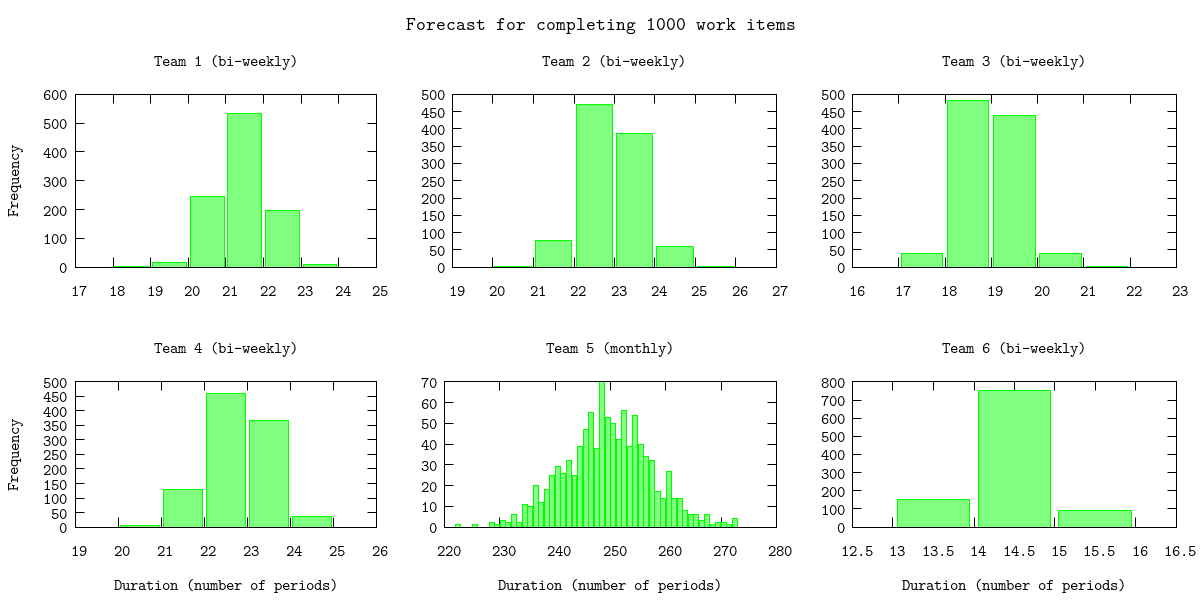

In [17]:
P.multi([
    P.histogram(t1[:mc_size]["all"],plottitle: "Team 1 (bi-weekly)",ylabel: "Frequency", mode: :as_commands),
    P.histogram(t2[:mc_size]["all"],plottitle: "Team 2 (bi-weekly)", mode: :as_commands),
    P.histogram(t3[:mc_size]["all"],plottitle: "Team 3 (bi-weekly)", mode: :as_commands),
    P.histogram(t4[:mc_size]["all"],plottitle: "Team 4 (bi-weekly)",xlabel: "Duration (number of periods)",ylabel: "Frequency", mode: :as_commands),

    P.histogram(t5[:mc_size]["all"],plottitle: "Team 5 (monthly)",xlabel: "Duration (number of periods)", mode: :as_commands),
    P.histogram(t6[:mc_size]["all"],plottitle: "Team 6 (bi-weekly)",xlabel: "Duration (number of periods)", mode: :as_commands),
],columns: 3, title: "Forecast for completing #{size} work items", size: "1200,600")
:"this is an inline image"

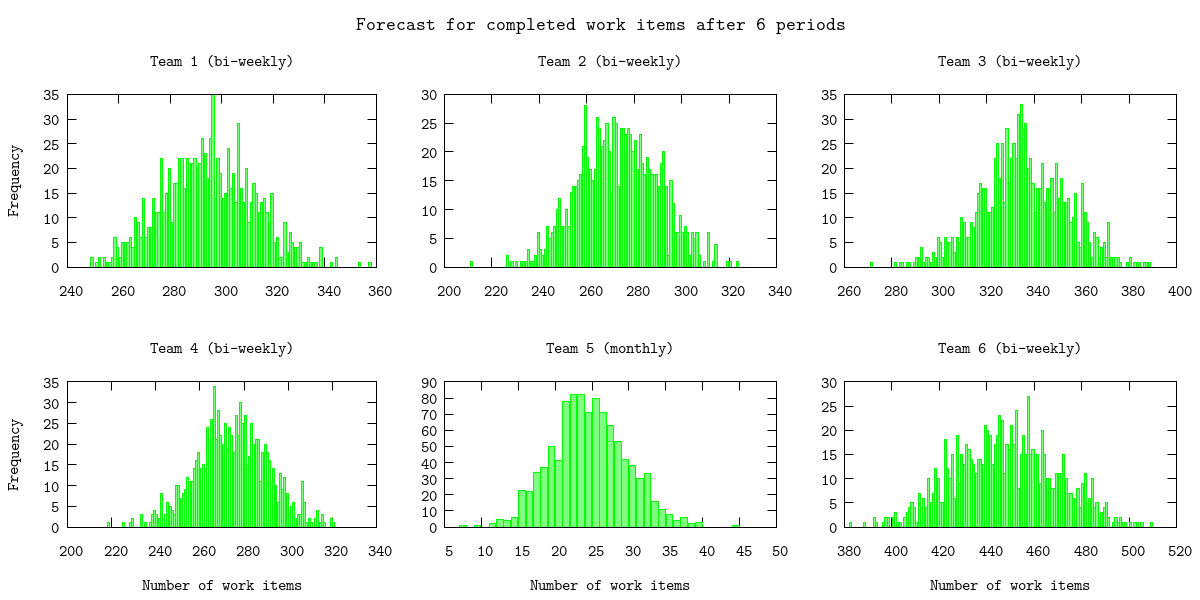

In [18]:
P.multi([
    P.histogram(t1[:mc_periods]["all"],plottitle: "Team 1 (bi-weekly)",ylabel: "Frequency", mode: :as_commands),
    P.histogram(t2[:mc_periods]["all"],plottitle: "Team 2 (bi-weekly)", mode: :as_commands),
    P.histogram(t3[:mc_periods]["all"],plottitle: "Team 3 (bi-weekly)", mode: :as_commands),
    P.histogram(t4[:mc_periods]["all"],plottitle: "Team 4 (bi-weekly)",xlabel: "Number of work items",ylabel: "Frequency", mode: :as_commands),

    P.histogram(t5[:mc_periods]["all"],plottitle: "Team 5 (monthly)",xlabel: "Number of work items", mode: :as_commands),
    P.histogram(t6[:mc_periods]["all"],plottitle: "Team 6 (bi-weekly)",xlabel: "Number of work items", mode: :as_commands),
],columns: 3, title: "Forecast for completed work items after #{periods} periods", size: "1200,600")
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf